In [34]:
import numpy as np
import  pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
plt.rcParams["font.size"] = 14
price = "2019 PRICE VAR [%]"

In [39]:
# Use for all the same features
data = pd.read_csv("Cleaned_2018.csv")
data2 = pd.read_csv("Cleaned_2017.csv")
data3 = pd.read_csv("Cleaned_2016.csv")
data4 = pd.read_csv("Cleaned_2015.csv")
data5 = pd.read_csv("Cleaned_2014.csv")

data_price = data.loc[:, ["2019 PRICE VAR [%]"]]
data_price2 = data2.loc[:, ["2018 PRICE VAR [%]"]]
data_price3 = data3.loc[:, ["2017 PRICE VAR [%]"]]
data_price4 = data4.loc[:, ["2016 PRICE VAR [%]"]]
data_price5 = data5.loc[:, ["2015 PRICE VAR [%]"]]

a = []
for i in list(data):
  if i in list(data2) and i in list(data3) and i in list(data4) and i in list(data5):
      a.append(i)

data = data[list(a[1:])].join(data_price)
data2 = data2[list(a[1:])].join(data_price2)
data3 = data3[list(a[1:])].join(data_price3)
data4 = data4[list(a[1:])].join(data_price4)
data5 = data5[list(a[1:])].join(data_price5)
print(list(data3))

['Revenue', 'Gross Profit', 'SG&A Expense', 'Operating Expenses', 'Operating Income', 'Earnings before Tax', 'Net Income', 'Net Income Com', 'EPS', 'EPS Diluted', 'Weighted Average Shs Out (Dil)', 'Gross Margin', 'EBIT Margin', 'EBITDA', 'EBIT', 'Consolidated Income', 'Earnings Before Tax Margin', 'Net Profit Margin', 'Cash and cash equivalents', 'Property, Plant & Equipment Net', 'Total assets', 'Total liabilities', 'Retained earnings (deficit)', 'Total shareholders equity', 'Depreciation & Amortization', 'Operating Cash Flow', 'Capital Expenditure', 'Investing Cash flow', 'Financing Cash Flow', 'Net cash flow / Change in cash', 'Free Cash Flow', 'assetTurnover', 'Income Quality', 'Tangible Asset Value', 'Gross Profit Growth', 'Operating Income Growth', 'Operating Cash Flow growth', 'Class', 'Sector', '2017 PRICE VAR [%]']


In [36]:
reg = sm.OLS(data.Revenue, exog=sm.add_constant(data[price])).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     18.17
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           2.06e-05
Time:                        19:26:32   Log-Likelihood:            -1.0435e+05
No. Observations:                4373   AIC:                         2.087e+05
Df Residuals:                    4371   BIC:                         2.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.848e+09   9.01

/Users/josip/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


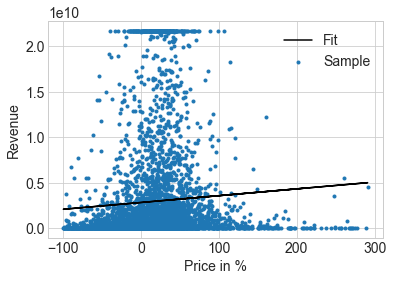

In [37]:
plt.scatter(data[price], data.Revenue, marker=".", label="Sample")
plt.plot(data[price], reg.fittedvalues, c="k", label="Fit")
plt.ylabel("Revenue")
plt.xlabel("Price in %")
plt.legend()

In [38]:
Xtrain = data[["Revenue", "Retained earnings (deficit)"]]
ytrain = data[["Class"]]


log_reg = sm.Logit(ytrain, Xtrain).fit()
print(log_reg)


# defining the dependent and independent variables
Xtest = data2[["Revenue", "Revenue Growth"]]
ytest = data2[['Class']]

# performing predictions on the test datdaset
yhat = log_reg.predict(Xtest)
prediction = list(map(round, yhat))

# comparing original and predicted values of y
print('Actual values', list(ytest.values))
print('Predictions :', prediction)

ValueError: endog must be in the unit interval.

In [ ]:
from sklearn.metrics import (confusion_matrix,
                           accuracy_score)

# confusion matrix
cm = confusion_matrix(ytest, prediction)
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Test accuracy = ', accuracy_score(ytest, prediction))